## Deconvolution test image for CLij Z tiling    

In this example we design a test image for CLIJ Z tiling



# Imports 

In [1]:
import numpy as np

from tnia.deconvolution.forward import forward
from tnia.plotting.projections import show_xyz_slice, show_xyz_max

## Create the phantom

Draw some spheres in the image

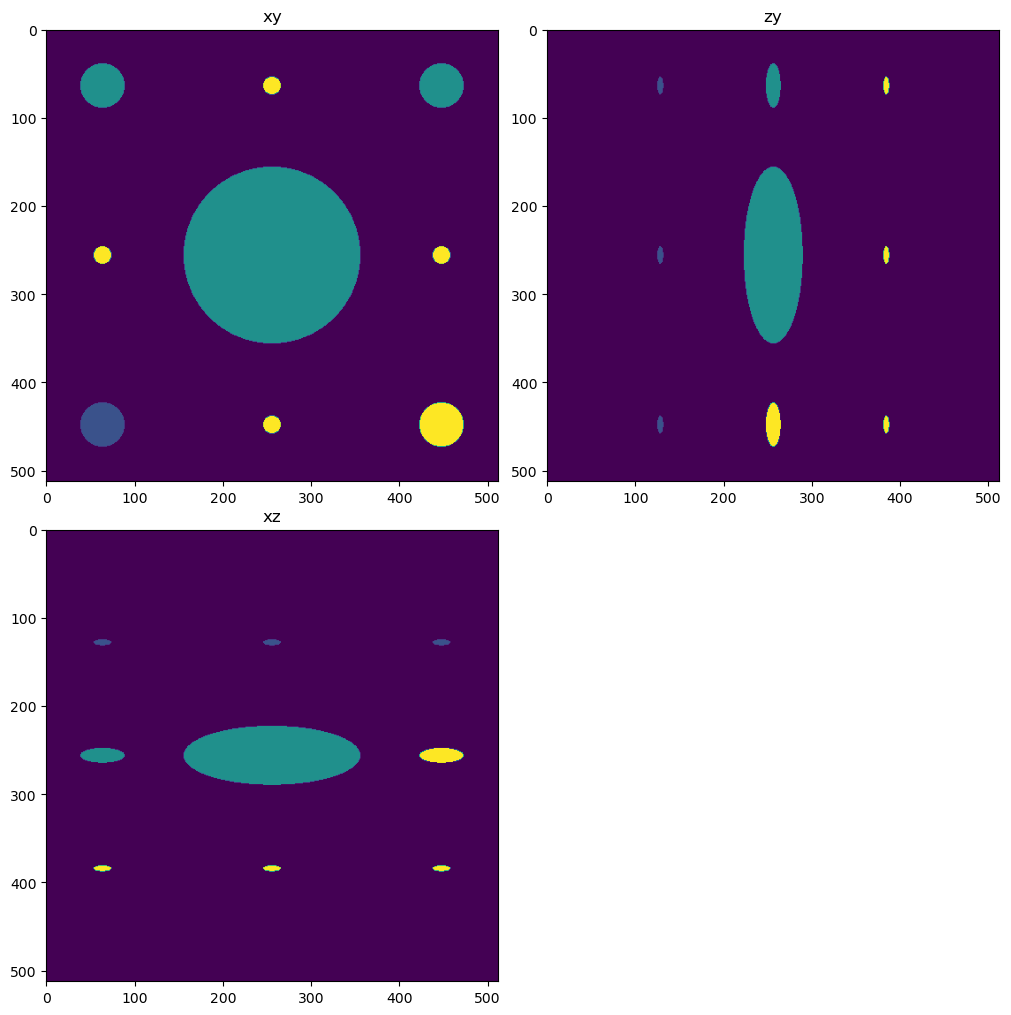

In [2]:
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large

gain = 400
background = 0 

zdim = 512*3
ydim = 512
xdim = 512

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

r=100
r_small=10
r_medium=25
size = [2*r, 2*r, 2*r]
size_small = [2*r_small, 2*r_small, 2*r_small]
size_medium = [2*r_medium, 2*r_medium, 2*r_medium]

sphere = rg.sphere(size, r).astype(np.float32)
small_sphere = rg.sphere(size_small, r_small).astype(np.float32)
medium_sphere = rg.sphere(size_medium, r_medium).astype(np.float32)

x=100
y=100
z=50


add_small_to_large(phantom, sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//2)

add_small_to_large(phantom, medium_sphere, phantom.shape[2]//8, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, 0.5*medium_sphere, phantom.shape[2]//8, 7*phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, medium_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, 2*medium_sphere, 7*phantom.shape[2]//8, 7*phantom.shape[1]//8, phantom.shape[0]//2)

add_small_to_large(phantom, small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//2)

add_small_to_large(phantom, 0.5*small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, 0.5*small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, 0.5*small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//4)
add_small_to_large(phantom, 0.5*small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//4)

add_small_to_large(phantom, 2*small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 2*small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 2*small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 2*small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, 3*phantom.shape[0]//4)

phantom = phantom[::3,:,:]
phantom = phantom*gain

fig = show_xyz_max(phantom)

## Create the forward PSF and deconvolution PSF

Note that the forward PSF (the PSF that explains the image) is not equal to the digital PSF used for deconvolution.  Among other imperfect approximations the PSF used for deconvolution can have smaller spatial extent.  In this simulation the PSF we use for convolution (ie in the simulation) is different than the PSF used for deconvolution.  We can change the parameters of the deconvolution PSF to study how differences between the real PSF and the digital PSF we use for deconvolution affects the result. 

Two factors which are important but may also be only approximately known are the refractive index of the biological sample and the depth of the sample (below the cover lens).  These two factors combine to produce spherical aberration in the PSF.

If there is aberration in the true PSF of the system, to get a good deconvololution result that aberration must be matched in the sample. 

In [3]:
phantom.shape

(512, 512, 512)

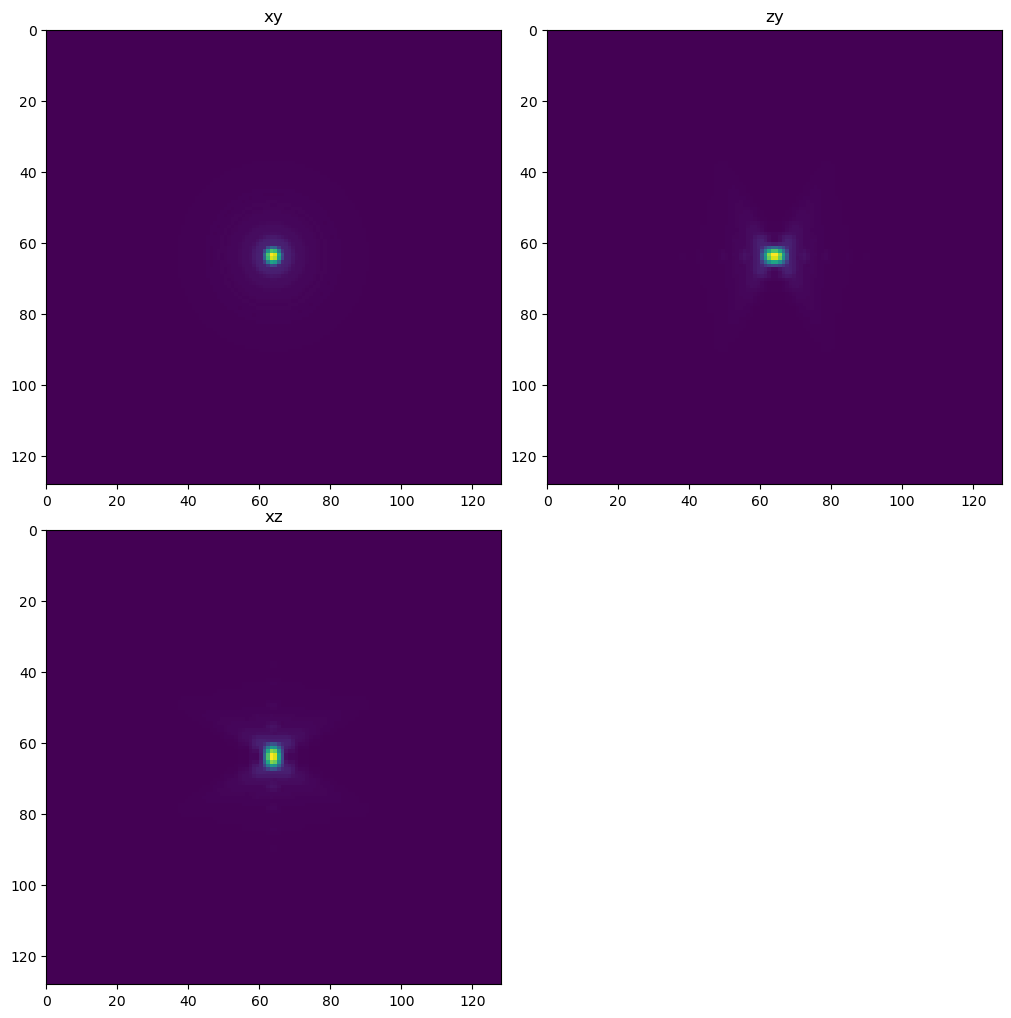

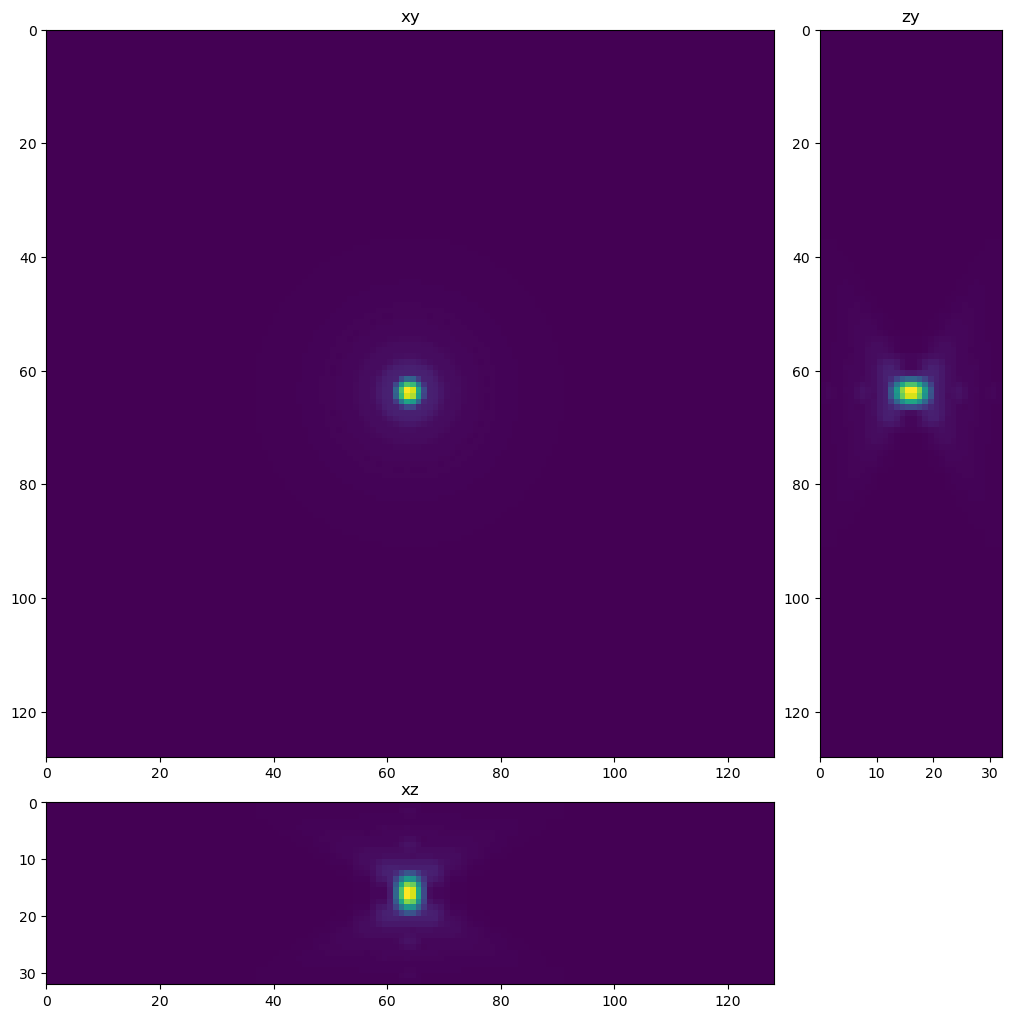

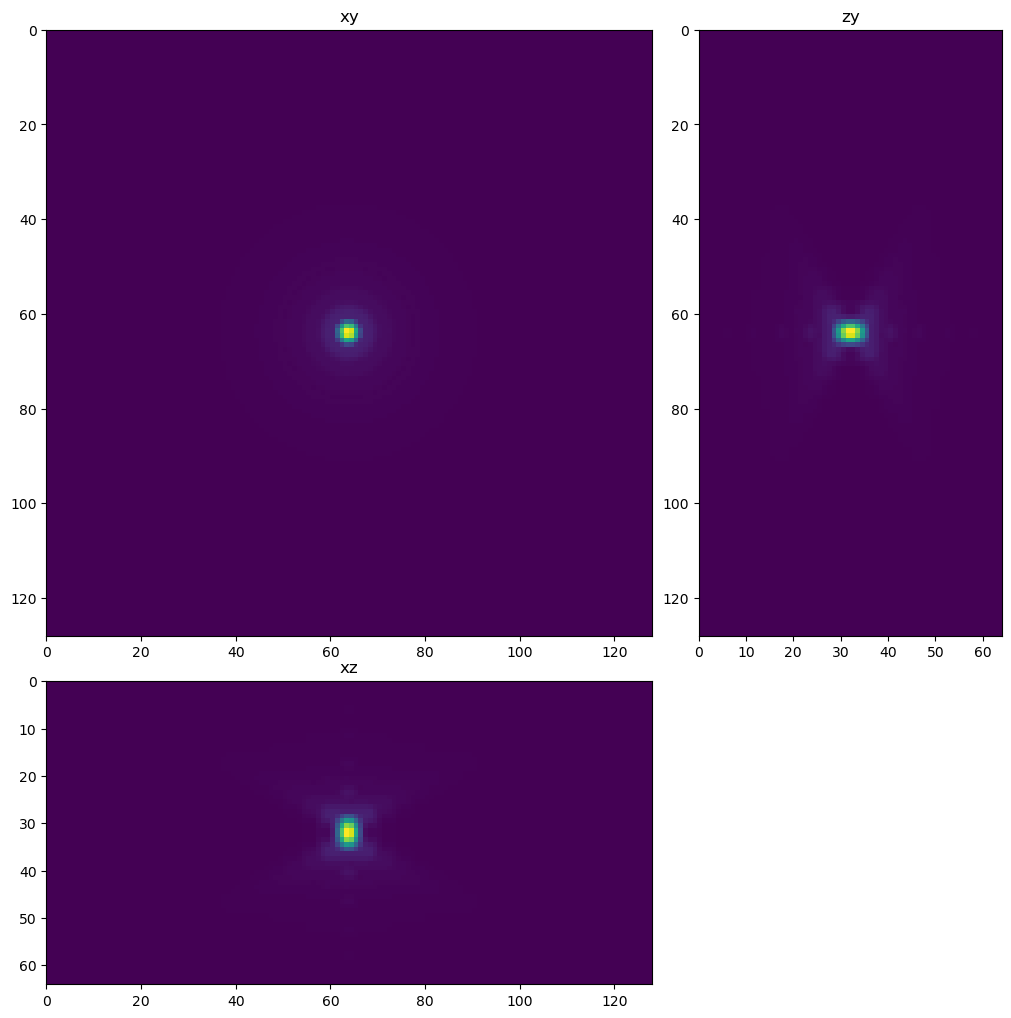

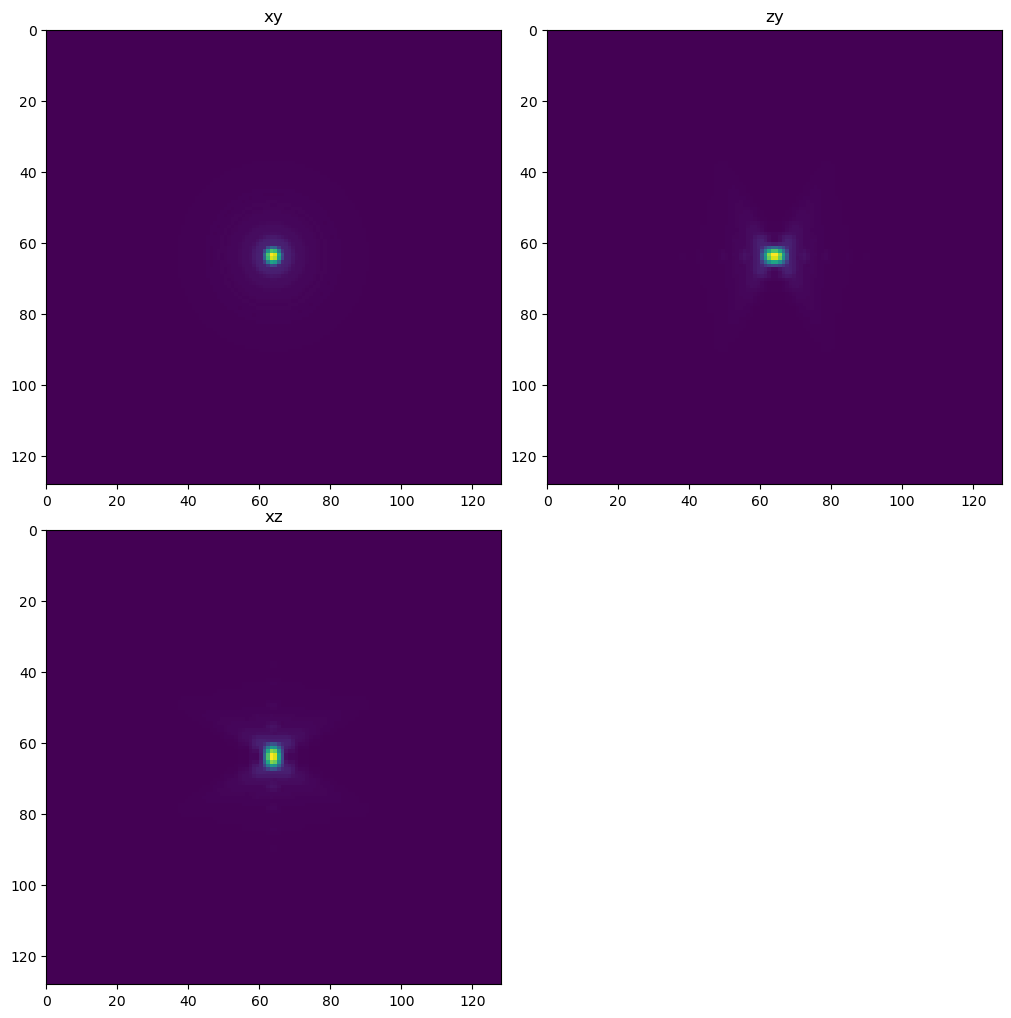

In [4]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.1
z_voxel_size=0.3

sxy = 1
sz = z_voxel_size/x_voxel_size

xy_psf_dim_forward=128
z_psf_dim_forward=128

NA=0.7

# ni is the refractive index of the immersion medium of the lens
ni=1
# ns is the refractive index of the sample
ns=1.33

# depth at which to calculate the PSF (note if there is a RI mismatch between the lens RI and sample RI spherical aberration will be introduced
# which will be depth dependent)
#depth_forward = 10
depth_forward = 0
depth_decon = 0 

psf_forward  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_forward, z_psf_dim_forward, depth_forward, 0.5, False, True)
psf_forward = psf_forward.astype('float32')
psf_forward = psf_forward/psf_forward.sum()

fig = show_xyz_max(psf_forward)

psf_decons_sizes = [(128, 32), (128, 64), (128,128)]
psfs = []
for s in psf_decons_sizes:
    psf=gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, s[0], s[1], depth_decon, 0.5, False, True)
    psf = psf.astype('float32')
    psf = psf/psf.sum()
    psfs.append(psf)
    fig = show_xyz_max(psf)

## Apply the forward model

In this case the forward model is convolution with the PSF and the addition of Poisson noise.  

What other factors will cause error between the true shape of the sample and the acquired image? 

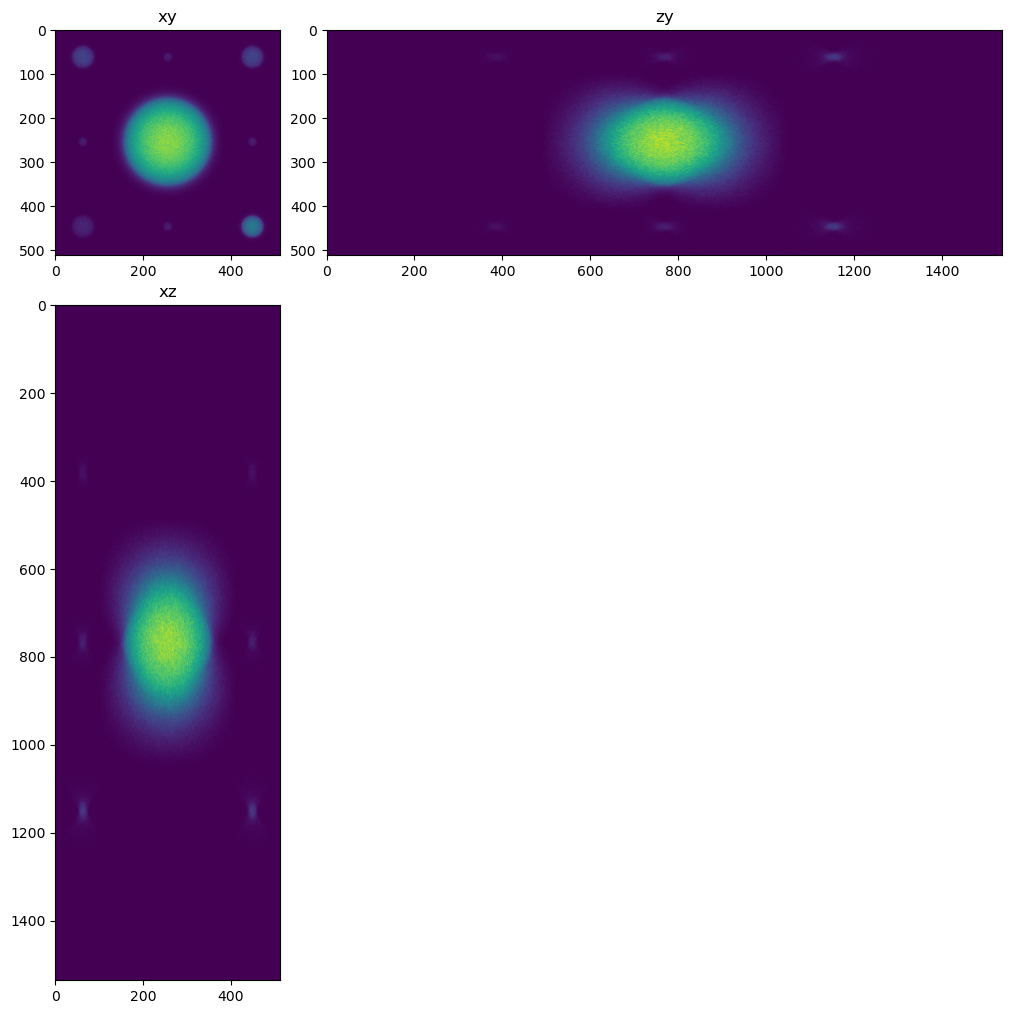

In [5]:
from tnia.deconvolution.forward import forward
from tnia.nd.ndutil import centercrop

im = forward(phantom, psf_forward, background, True, True)

x_v = im.shape[2]//2
y_v = im.shape[1]//2
z_v = im.shape[0]//2

phantom=phantom+background

fig = show_xyz_slice(im, x_v, y_v, z_v, sxy=sxy, sz=sz)

In [8]:
from pathlib import Path   
from skimage.io import imsave

tnia_images_path = Path(r'D:/images')
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_02_15_clij_z_tiling')

imsave(parent_path / 'phantom.tif', phantom)
imsave(parent_path / 'psf.tif', psf_forward)
imsave(parent_path / 'im.tif', im)

for i, psf in enumerate(psfs):
    imsave(parent_path / f'psf_{i}.tif', psf)


C:\Users\bnort\AppData\Local\Temp\ipykernel_24792\476357661.py:8: UserWarning: D:\images\tnia-python-images\imagesc\2024_02_15_clij_z_tiling\psf.tif is a low contrast image
  imsave(parent_path / 'psf.tif', psf_forward)
C:\Users\bnort\AppData\Local\Temp\ipykernel_24792\476357661.py:12: UserWarning: D:\images\tnia-python-images\imagesc\2024_02_15_clij_z_tiling\psf_0.tif is a low contrast image
  imsave(parent_path / f'psf_{i}.tif', psf)
C:\Users\bnort\AppData\Local\Temp\ipykernel_24792\476357661.py:12: UserWarning: D:\images\tnia-python-images\imagesc\2024_02_15_clij_z_tiling\psf_1.tif is a low contrast image
  imsave(parent_path / f'psf_{i}.tif', psf)
C:\Users\bnort\AppData\Local\Temp\ipykernel_24792\476357661.py:12: UserWarning: D:\images\tnia-python-images\imagesc\2024_02_15_clij_z_tiling\psf_2.tif is a low contrast image
  imsave(parent_path / f'psf_{i}.tif', psf)
